In [7]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from ml_wireless_classification.base.SignalUtils import extract_comprehensive_features

# Define combined feature set for QAM16 vs QAM64 classification
QAM_FEATURES = [
    "SNR", "PAPR", "Kurtosis Magnitude", "Skewness Magnitude",
    "Adaptive Gaussian Filtering (Frequency Domain)", "Spectral Energy Density (Real)",
    "Autocorrelation Skewness (Quartic)", "Spectral Peak Ratio (Real)",
    "Energy Spread Time-Frequency (Gaussian)", "Phase Modulation Skewness (Quartic)",
    "Spectral Concentration Around Center", "Temporal Peak Density (Quadratic)",
    "Zero-Crossing Density (Frequency Domain)", "Frequency Modulation Rate",
    "Normalized High-Frequency Power Ratio", "Spectral Modulation Bandwidth (Quadratic)",
    "Amplitude Spectral Flatness (Real)", "Wavelet Entropy Multiple Scales (Quadratic)",
    "High-Frequency Spectral Entropy (Cubic)"
]

def filter_qam_data(data):
    filtered_data = {}
    for key, signals in data.items():
        mod_type, snr = key
        if mod_type in ["QAM16", "QAM64"]:
            filtered_data[key] = signals

    # Verify that only QAM16 and QAM64 remain in the filtered data
    unique_mod_types = set([mod_type for mod_type, _ in filtered_data.keys()])
    print(f"Filtered data contains {len(unique_mod_types)} unique modulation types: {unique_mod_types}")

    return filtered_data

def extract_qam_features(data, selected_features):
    features = []
    labels = []
    snr_values = []

    for key, signals in data.items():
        mod_type, snr = key
        for signal in signals:
            real_part, imag_part = signal[0], signal[1]
            complex_signal = real_part + 1j * imag_part

            # Compute features for real and imaginary parts separately
            real_feature_dict = extract_comprehensive_features(real_part, real_part, selected_features)
            imag_feature_dict = extract_comprehensive_features(imag_part, imag_part, selected_features)

            # Add SNR to both real and imaginary feature dictionaries
            real_feature_dict["SNR"] = snr
            imag_feature_dict["SNR"] = snr

            # Collect selected features for real and imaginary channels
            real_features = [real_feature_dict.get(feat, 0) for feat in selected_features]
            imag_features = [imag_feature_dict.get(feat, 0) for feat in selected_features]

            # Concatenate real and imaginary features
            combined_features = real_features + imag_features
            features.append(combined_features)
            labels.append(mod_type)
            snr_values.append(snr)  # Store the SNR for this sample

    print(f"Extracted {len(features)} samples with all selected features.")
    return np.array(features), labels, np.array(snr_values)

# Load data and filter for QAM16 and QAM64
with open("../RML2016.10a_dict.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")

# Filter data to include only QAM16 and QAM64
qam_data = filter_qam_data(data)

# Extract features, labels, and SNR values
qam_features, qam_labels, snr_values = extract_qam_features(qam_data, QAM_FEATURES)

# Ensure we have sufficient data
if len(qam_features) == 0:
    raise ValueError("No data found after filtering. Please check the feature extraction and data filtering steps.")

# Encode labels to binary classes (0 for QAM16, 1 for QAM64)
qam_labels = np.array([0 if label == "QAM16" else 1 for label in qam_labels])

# Split the data into training and testing sets, including SNR values
X_train, X_test, y_train, y_test, snr_train, snr_test = train_test_split(
    qam_features, qam_labels, snr_values, test_size=0.3, random_state=42
)


Filtered data contains 2 unique modulation types: {'QAM64', 'QAM16'}
Extracted 40000 samples with all selected features.


In [8]:

# Train the RandomForestClassifier
qam_model = RandomForestClassifier(n_estimators=100, random_state=42)
qam_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

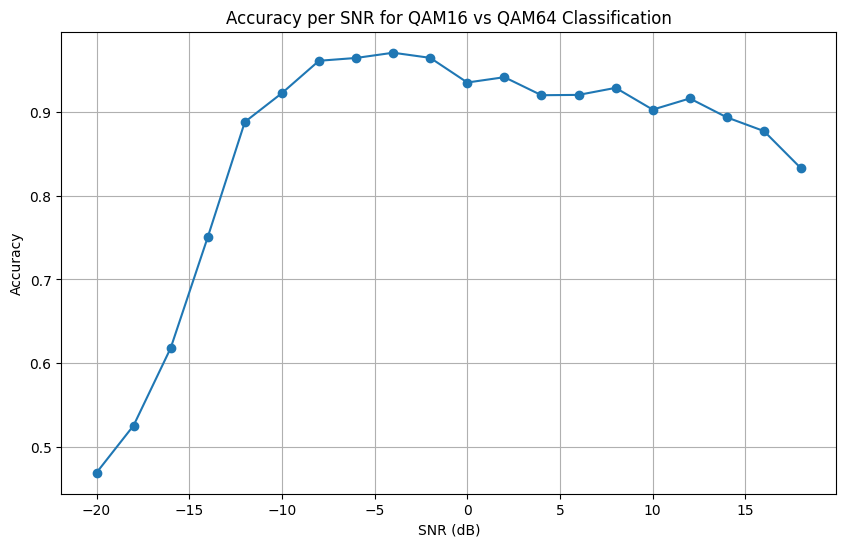

QAM16 vs QAM64 Model Performance
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      5971
           1       0.87      0.84      0.85      6029

    accuracy                           0.85     12000
   macro avg       0.85      0.85      0.85     12000
weighted avg       0.85      0.85      0.85     12000

[[5195  776]
 [ 973 5056]]


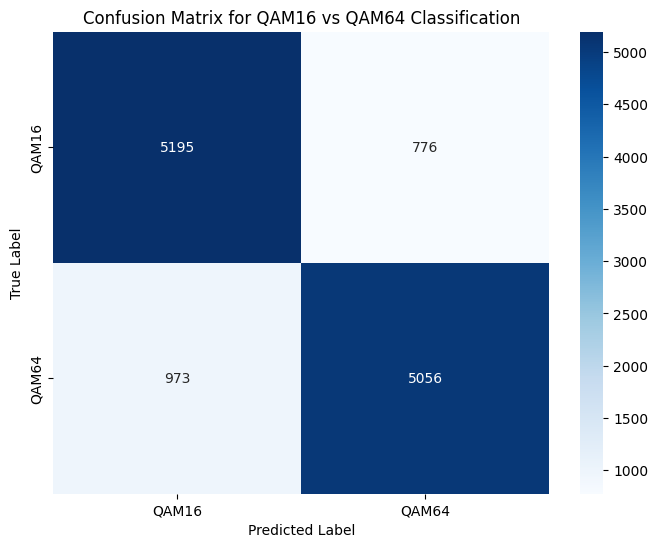

In [9]:

# Predictions and Evaluation
qam_pred = qam_model.predict(X_test)

# Compute accuracy per SNR
snr_accuracy = {}
unique_snr_values = np.unique(snr_test)

for snr in unique_snr_values:
    indices = np.where(snr_test == snr)
    accuracy = accuracy_score(y_test[indices], qam_pred[indices])
    snr_accuracy[snr] = accuracy

# Plotting accuracy per SNR
plt.figure(figsize=(10, 6))
plt.plot(list(snr_accuracy.keys()), list(snr_accuracy.values()), marker='o')
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.title("Accuracy per SNR for QAM16 vs QAM64 Classification")
plt.grid(True)
plt.show()

# Display the confusion matrix for overall performance
print("QAM16 vs QAM64 Model Performance")
print(classification_report(y_test, qam_pred))
print(confusion_matrix(y_test, qam_pred))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, qam_pred), annot=True, fmt='d', cmap='Blues', xticklabels=["QAM16", "QAM64"], yticklabels=["QAM16", "QAM64"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for QAM16 vs QAM64 Classification")
plt.show()


2024-11-14 15:27:11.695697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 15:27:11.697416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 15:27:11.698325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

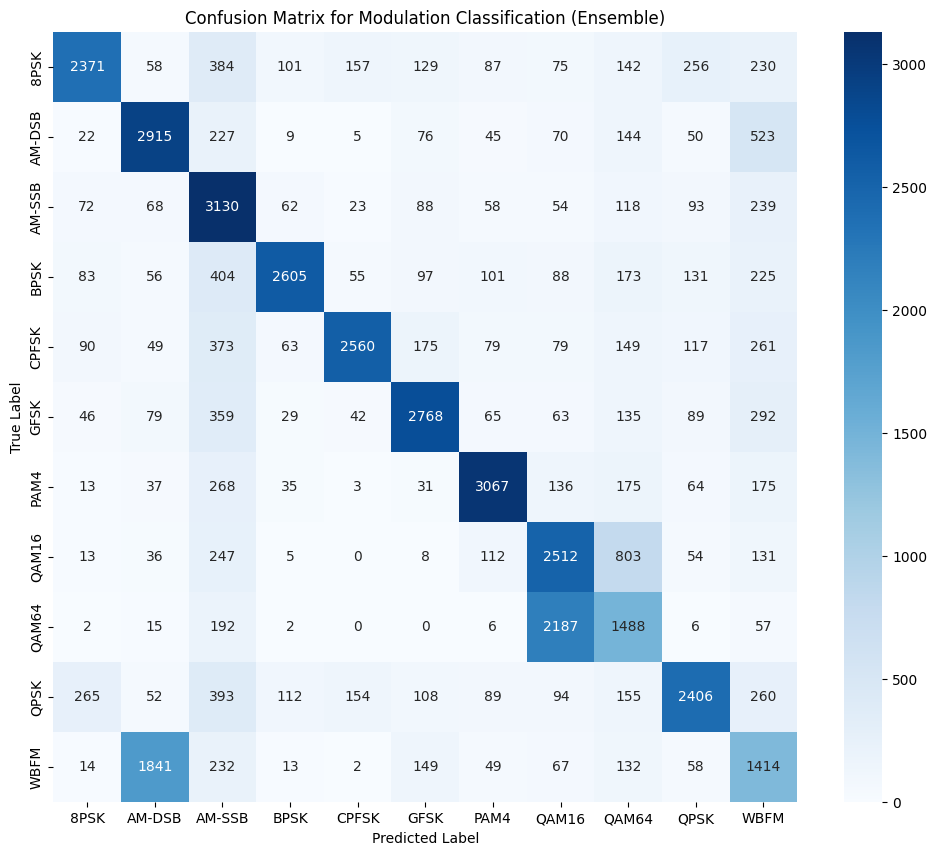

Classification Report for Modulation Types (Ensemble):
              precision    recall  f1-score   support

        8PSK       0.79      0.59      0.68      3990
      AM-DSB       0.56      0.71      0.63      4086
      AM-SSB       0.50      0.78      0.61      4005
        BPSK       0.86      0.65      0.74      4018
       CPFSK       0.85      0.64      0.73      3995
        GFSK       0.76      0.70      0.73      3967
        PAM4       0.82      0.77      0.79      4004
       QAM16       0.46      0.64      0.54      3921
       QAM64       0.41      0.38      0.39      3955
        QPSK       0.72      0.59      0.65      4088
        WBFM       0.37      0.36      0.36      3971

    accuracy                           0.62     44000
   macro avg       0.65      0.62      0.62     44000
weighted avg       0.65      0.62      0.62     44000



In [18]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model

# Prepare the data using your specific format
def prepare_data(data):
    X, y = [], []

    for (mod_type, snr), signals in data.items():
        for signal in signals:
            iq_signal = np.vstack([signal[0], signal[1]]).T
            snr_signal = np.full((128, 1), snr)
            combined_signal = np.hstack([iq_signal, snr_signal])
            X.append(combined_signal)
            y.append(mod_type)

    X = np.array(X)
    y = np.array(y)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42
    )
    X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2])
    X_test = X_test.reshape(-1, X_test.shape[1], X_test.shape[2])

    return X_train, X_test, y_train, y_test, label_encoder


# Load the Random Forest model (assuming it's already trained)
# Assuming qam_model is your trained RandomForestClassifier

# Load the RNN/LSTM model
model_path = "../src/ml_wireless_classification/models/rnn_lstm_w_SNR.keras"
rnn_model = load_model(model_path)


# Prepare the data using your specific format
X_train, X_test, y_train, y_test, label_encoder = prepare_data(data)
def extract_rf_features(iq_sample):
    """
    Extract the required 38 features for the Random Forest model from the IQ data.
    19 features will be computed from the real part and 19 from the imaginary part.
    """
    real_part = iq_sample[:, 0]  # Extract real component
    imag_part = iq_sample[:, 1]  # Extract imaginary component
    
    # Ensure only selected features are extracted for real and imaginary parts
    real_feature_dict = extract_comprehensive_features(real_part + 0j, real_part, selected_features=QAM_FEATURES)
    imag_feature_dict = extract_comprehensive_features(imag_part + 0j, imag_part, selected_features=QAM_FEATURES)
    
    # Initialize feature lists with default values for missing features
    rf_features_real = [real_feature_dict.get(feat, 0) for feat in QAM_FEATURES[:19]]
    rf_features_imag = [imag_feature_dict.get(feat, 0) for feat in QAM_FEATURES[:19]]
    
    # Concatenate real and imaginary features to form the full 38-feature vector
    rf_features = rf_features_real + rf_features_imag
    
    return np.array(rf_features)


# Define the ensemble prediction function with feature extraction for RF model
def ensemble_predict(X_test):
    # RNN/LSTM model predictions
    y_pred_rnn = np.argmax(rnn_model.predict(X_test, verbose=False), axis=1)
    
    # Decode RNN predictions to modulation types
    rnn_modulations = label_encoder.inverse_transform(y_pred_rnn)
    
    # Final predictions array
    y_pred_final = []
    
    # Loop through each RNN/LSTM prediction
    for i, mod_type in enumerate(rnn_modulations):
        snr_value = X_test[i, 0, 2]  # Assuming SNR is in the third column of each sample
        
        if mod_type in ["QAM16", "QAM64"] and -11 <= snr_value <= 11:
            # Use Random Forest model for QAM16 or QAM64 if SNR is within the specified range
            rf_features = np.real(extract_rf_features(X_test[i]))  # Extract 38 features for the RF model
            rf_pred = qam_model.predict([rf_features])[0]
            
            # Map RF prediction back to the encoded label (0 for QAM16, 1 for QAM64)
            rf_mod_type = "QAM16" if rf_pred == 0 else "QAM64"
            rf_encoded_label = label_encoder.transform([rf_mod_type])[0]
            y_pred_final.append(rf_encoded_label)
        else:
            # Use RNN/LSTM model's prediction for other modulation types or if SNR is outside the specified range
            y_pred_final.append(y_pred_rnn[i])
    
    return np.array(y_pred_final)

# Perform ensemble predictions
X_test = np.real(X_test)
y_test = np.real(y_test)
y_pred_ensemble = ensemble_predict(X_test)

# Plot the overall confusion matrix for the ensemble
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Modulation Classification (Ensemble)")
plt.show()

# Print the overall classification report for the ensemble
print("Classification Report for Modulation Types (Ensemble):")
print(classification_report(y_test, y_pred_ensemble, target_names=label_encoder.classes_))



/home/eng/python/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/home/eng/python/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:462: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,
/home/eng/workspace/ML-wireless-signal-classification/src/ml_wireless_classification/base/SignalUtils.py:644: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, Zxx = stft(signal, fs=fs, nperseg=128)
/home/eng/python/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/home/eng/python/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:462: UserW

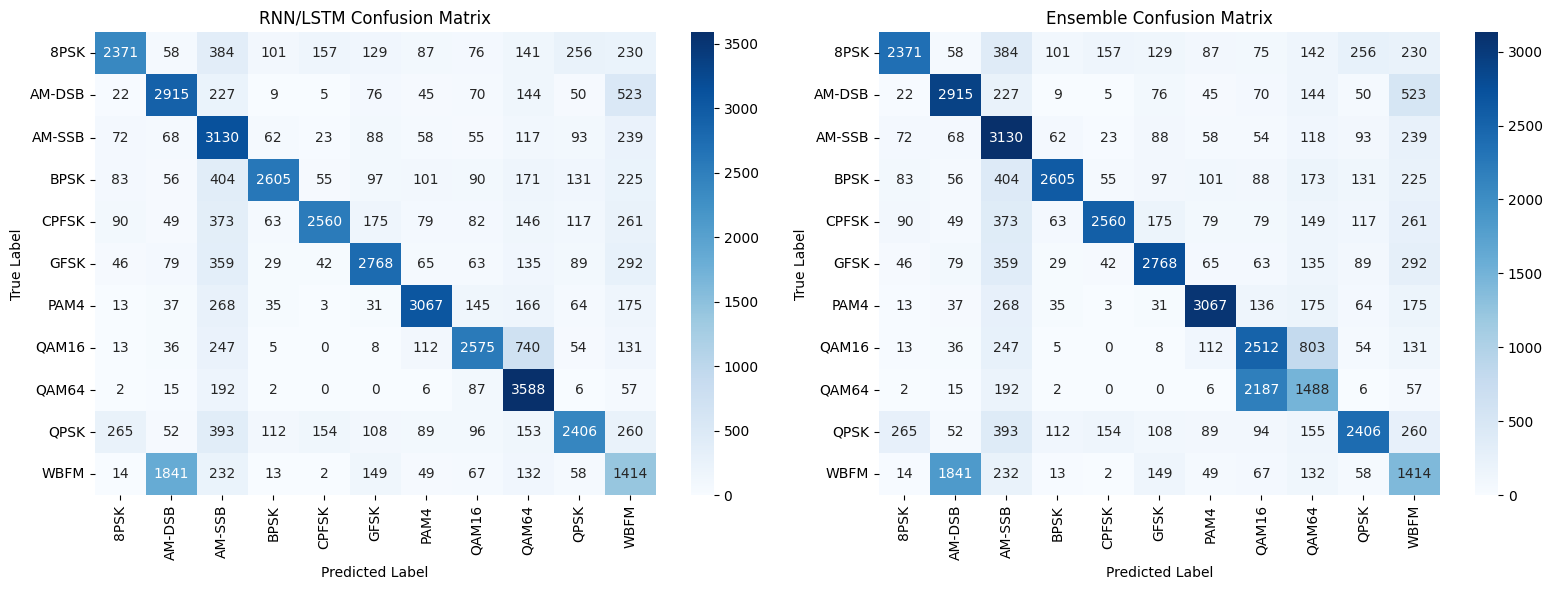

Classification Report for RNN/LSTM Model:
              precision    recall  f1-score   support

        8PSK       0.79      0.59      0.68      3990
      AM-DSB       0.56      0.71      0.63      4086
      AM-SSB       0.50      0.78      0.61      4005
        BPSK       0.86      0.65      0.74      4018
       CPFSK       0.85      0.64      0.73      3995
        GFSK       0.76      0.70      0.73      3967
        PAM4       0.82      0.77      0.79      4004
       QAM16       0.76      0.66      0.70      3921
       QAM64       0.64      0.91      0.75      3955
        QPSK       0.72      0.59      0.65      4088
        WBFM       0.37      0.36      0.36      3971

    accuracy                           0.67     44000
   macro avg       0.69      0.67      0.67     44000
weighted avg       0.69      0.67      0.67     44000


Classification Report for Ensemble Model:
              precision    recall  f1-score   support

        8PSK       0.79      0.59      0.68    

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Function to plot confusion matrices side by side
def plot_confusion_matrices(y_test, y_pred_rnn, y_pred_ensemble, label_encoder):
    # Calculate confusion matrices
    conf_matrix_rnn = confusion_matrix(y_test, y_pred_rnn)
    conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot RNN/LSTM Confusion Matrix
    sns.heatmap(conf_matrix_rnn, annot=True, fmt="d", cmap="Blues", 
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[0])
    axes[0].set_title("RNN/LSTM Confusion Matrix")
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")
    
    # Plot Ensemble Confusion Matrix
    sns.heatmap(conf_matrix_ensemble, annot=True, fmt="d", cmap="Blues", 
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[1])
    axes[1].set_title("Ensemble Confusion Matrix")
    axes[1].set_xlabel("Predicted Label")
    axes[1].set_ylabel("True Label")
    
    plt.tight_layout()
    plt.show()

# Generate RNN/LSTM standalone predictions
y_pred_rnn = np.argmax(rnn_model.predict(X_test, verbose=False), axis=1)

# Generate ensemble predictions
y_pred_ensemble = ensemble_predict(X_test)

# Plot confusion matrices
plot_confusion_matrices(y_test, y_pred_rnn, y_pred_ensemble, label_encoder)

# Print classification report for both models
print("Classification Report for RNN/LSTM Model:")
print(classification_report(y_test, y_pred_rnn, target_names=label_encoder.classes_))

print("\nClassification Report for Ensemble Model:")
print(classification_report(y_test, y_pred_ensemble, target_names=label_encoder.classes_))
